# 用 LSTM 做时间序列预测

In [2]:
import math
import numpy
from datetime import datetime
import matplotlib.pyplot as plt
from keras.utils import print_summary
from keras.models import load_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import sys 
sys.path.append(r'D:\\xueqing\\workplace\\lstm\\Time-Series-Prediction-with-LSTM')  # 要用绝对路径
from utils import data_tools, networks_factory, data_metrics
from utils.constants import const
%matplotlib inline

In [3]:
# fix random seed for reproducibility
numpy.random.seed(7)

## 导入数据

# shape:  (1901, 1)


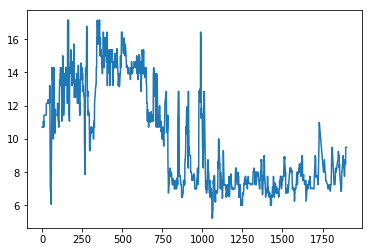

In [4]:
dataset, dates = data_tools.load_data_from_csv(const.DATA_DIR + "apple_interpolate.csv")
print("# shape: ", dataset.shape)

# plot
plt.plot(dataset)
plt.show()

## 数据转化与处理

In [5]:
# normalize the dataset
scaler = data_tools.Ne_MinMaxScaler
scaled_dataset = scaler.fit_transform(dataset)
print(scaled_dataset.shape)

(1901, 1)


In [5]:
# reshape into X=t and Y=t+1
look_back = 13
dataX, dataY = data_tools.create_dataset(scaled_dataset, look_back)
dataY = dataY.reshape((len(dataY), 1))  # to be two dims for inverse_transform
print("# shape: ", dataX.shape)  # lenth 应等于 len(dataset)-look_back
print("# shape: ", dataY.shape)

# shape:  (1888, 13)
# shape:  (1888, 1)


In [6]:
train_size = int(len(dataX) * const.TRAIN_SCALE)
test_size = len(dataX) - train_size
trainX, testX = dataX[0:train_size,:], dataX[train_size:len(dataset),:]
trainY, testY = dataY[0:train_size,:], dataY[train_size:len(dataset),:]
print("# lenth: ", len(trainX), len(testX))
print(len(dataX) == len(trainX)+len(testX))

# lenth:  1510 378
True


In [7]:
n_epoch = networks_factory.EPOCHS
n_batch_size = networks_factory.BATCH_SIZE

# BP

In [8]:
n_dims = trainX.shape[1]
s, model = networks_factory.create_bp_model(hidden_neurons=32, dims=n_dims, n_out=1)

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=n_epoch, batch_size=n_batch_size, validation_data=(testX, testY), 
                    verbose=0, callbacks=[networks_factory.ES]) 

Epoch 00276: early stopping


In [9]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
print("# shape: ", trainPredict.shape)

# invert predictions
inv_trainP = scaler.inverse_transform(trainPredict)
inv_trainY = scaler.inverse_transform(trainY)
inv_testP = scaler.inverse_transform(testPredict)
inv_testY = scaler.inverse_transform(testY)
print("# shape: ", inv_trainP.shape)

# calculate RMSE, MAPE, Dstat
train_rmse = math.sqrt(mean_squared_error(inv_trainP, inv_trainY))
test_rmse = math.sqrt(mean_squared_error(inv_testP, inv_testY))
print('Train RMSE: %.4f, Test RMSE: %.4f' % (train_rmse, test_rmse))
train_mape = data_metrics.MAPE(inv_trainP, inv_trainY)
test_mape = data_metrics.MAPE(inv_testP, inv_testY)
print('Train MAPE: %.4f, Test MAPE: %.4f' % (train_mape, test_mape))
train_ds = data_metrics.Dstat(inv_trainP, inv_trainY)
test_ds = data_metrics.Dstat(inv_testP, inv_testY)
print('Train Dstat: %.4f, Test Dstat: %.4f' % (train_ds, test_ds))

# shape:  (1510, 1)
# shape:  (1510, 1)
Train RMSE: 0.5908, Test RMSE: 0.2641
Train MAPE: 0.0351, Test MAPE: 0.0263
Train Dstat: 0.7210, Test Dstat: 0.6870


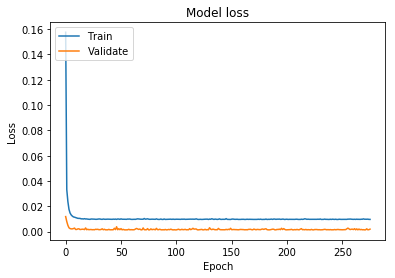

In [10]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

bp_val_loss = history.history['val_loss']

## 建立 LSTM /RNN模型

In [11]:
# reshape input to be [samples, time steps, features]
time_steps = look_back
trainX = numpy.reshape(trainX, (trainX.shape[0], time_steps, trainX.shape[1]//time_steps)) 
print(trainX.shape)
testX = numpy.reshape(testX, (testX.shape[0], time_steps, testX.shape[1]//time_steps))
print(testX.shape)

(1510, 13, 1)
(378, 13, 1)


## build model

In [12]:
n_dim = trainX.shape[2]
neural_nets_flags = [const.FLAG_NN_RNN, const.FLAG_NN_LSTM]
# neural_nets_flags = [const.FLAG_NN_LSTM]  # once

In [13]:
for i, neural_nets_flag in enumerate(neural_nets_flags):
    
    print("-----------neural_nets_flag: %s--------------" % const.FLAG_NN_STRING[neural_nets_flag])
    if (neural_nets_flag == const.FLAG_NN_RNN):
        s, model = networks_factory.create_rnn_model(hidden_neurons=networks_factory.HIDDEN_NEURONS, 
                                             lenth=time_steps, dims=n_dim, n_out=1)
    elif (neural_nets_flag == const.FLAG_NN_LSTM):
        s, model = networks_factory.create_lstm_model(lstm_neurons=networks_factory.HIDDEN_NEURONS, 
                                             hidden_layers=networks_factory.HIDDEN_LAYERS, 
                                             lenth=time_steps, dims=n_dim, n_out=1)
    else:
        pass
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(trainX, trainY, epochs=n_epoch, batch_size=n_batch_size, validation_data=(testX, testY), 
                        verbose=0, callbacks=[networks_factory.ES]) 
    
    if (neural_nets_flag == const.FLAG_NN_RNN):
        rnn_val_loss = history.history['val_loss']
    elif (neural_nets_flag == const.FLAG_NN_LSTM):
        lstm_val_loss = history.history['val_loss']
    
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # invert predictions
    inv_trainP = scaler.inverse_transform(trainPredict)
    inv_trainY = scaler.inverse_transform(trainY)
    inv_testP = scaler.inverse_transform(testPredict)
    inv_testY = scaler.inverse_transform(testY)

    # calculate RMSE, MAPE, Dstat
    train_rmse = math.sqrt(mean_squared_error(inv_trainP, inv_trainY))
    test_rmse = math.sqrt(mean_squared_error(inv_testP, inv_testY))
    print('Train RMSE: %.4f, Test RMSE: %.4f' % (train_rmse, test_rmse))
    train_mape = data_metrics.MAPE(inv_trainP, inv_trainY)
    test_mape = data_metrics.MAPE(inv_testP, inv_testY)
    print('Train MAPE: %.4f, Test MAPE: %.4f' % (train_mape, test_mape))
    train_ds = data_metrics.Dstat(inv_trainP, inv_trainY)
    test_ds = data_metrics.Dstat(inv_testP, inv_testY)
    print('Train Dstat: %.4f, Test Dstat: %.4f' % (train_ds, test_ds)) 
    
print("# All Done!") 

-----------neural_nets_flag: RNN--------------
Epoch 00283: early stopping
Train RMSE: 0.3845, Test RMSE: 0.2540
Train MAPE: 0.0245, Test MAPE: 0.0224
Train Dstat: 0.7641, Test Dstat: 0.7268
-----------neural_nets_flag: LSTM--------------
Epoch 00310: early stopping
Train RMSE: 0.5058, Test RMSE: 0.2377
Train MAPE: 0.0293, Test MAPE: 0.0208
Train Dstat: 0.7396, Test Dstat: 0.7613
# All Done!


## 画出结果

## Loss

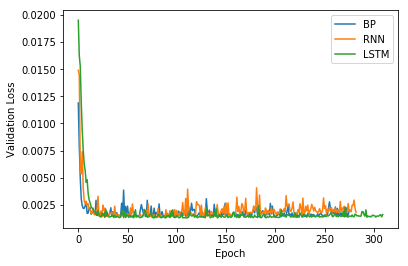

In [14]:
# Plot training & validation loss values
plt.plot(bp_val_loss)
plt.plot(rnn_val_loss)
plt.plot(lstm_val_loss)
# plt.title('Model validation loss')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend(['BP', 'RNN', 'LSTM'], loc='upper right')
plt.show()

## Predict

In [15]:
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:,:] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back,:] = inv_trainP[:]  # index from a to b-1

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:,:] = numpy.nan
testPredictPlot[len(trainPredict)+look_back:len(dataset),:] = inv_testP[:]

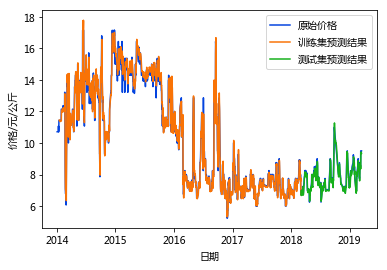

In [16]:
# 中文乱码的处理
plt.rcParams['font.sans-serif'] =['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
xs = [datetime.strptime(d, '%Y-%m-%d') for d in dates]

fig = plt.figure(1)
ax1 = plt.subplot(1, 1, 1)
l1, = ax1.plot(xs, dataset, color='xkcd:blue')
l2, = ax1.plot(xs, trainPredictPlot, color='xkcd:orange')
l3, = ax1.plot(xs, testPredictPlot, color='xkcd:green')

plt.ylabel('价格/元/公斤')
plt.xlabel('日期')
plt.legend([l1, l2, l3], ['原始价格', '训练集预测结果', '测试集预测结果'], loc='upper right')
plt.show()

参考：[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/"Title")